# Clustermethode: Poisson 🐟

Dit model deelt de lijn op in een aantal bakjes (elke **4 meter**), en accumeleert dan alle PDs per bakje. Hierbij kan PD-lading **wel of niet** worden meegenomen. (Een mogelijk verbeterpunt is dat de tijd ook wordt opgesplitst in een aantal delen.) Vervolgens wordt aangenomen dat **ten minste 80% van de kabel** nominaal PD-gedrag vertoont. 

De 80% van de bakjes met het laagste aantal PDs wordt gebruikt om een Poisson-verdeling te fitten voor nominaal PD-gedrag. (Hierbij wordt rekening gehouden met het feit dat alleen de 80% kleinste realisaties bekend zijn.)

Vervolgens wordt de volledige lijn weer beschouwd. Alle bakjes waarin het aantal PDs een onwaarschijnlijkheid heeft van **minimaal 5%**, _gegeven de gevonden verdeling voor nominaal PD-gedrag_, wordt als een zeer verdacht hokje beschouwd.

Ten slotte worden alle aangrenzende, zeer verdachte hokjes samengenomen tot een _cluster_. Twee clusters die **maximaal 2** hokjes uit elkaar liggen, worden als één cluster beschouwd. Er geldt ook beperking dat een cluster  **minimaal 3** verdachte hokjes moet bevatten, zoniet wordt het cluster genegeerd.

---------

## Parameters
De vijf **dikgedrukte** getallen zijn parameters die aangepast kunnen worden. De huidige keuze identificeert de gewenste resultaten. Wanneer er geen clusters zijn, wordt dit correct herkend.

Het aantal parameters lijkt hoog, maar dit zorgt er juist voor dat dezelfde parameters op alle circuits goed werken.

----------

## Snelheid

Zonder parallelisatie, op een Intel i5. Hierbij wordt het inladen (en plotten) van een dataset niet meegeteld.

**Circuit 2145 (hoogste aantal PDs)**

| Routine                                    | Tijd (`%%timeit`)    |
| ------------------------------------------ | -------------------- |
| Discretiseren; PDs tellen                  | 3.72 ms ± 88.5 µs    |
| 80% kwantiel bepalen                       | 9.51 µs ± 604 ns     |
| Poisson-verdeling fitten                   | 108 µs ± 3.21 µs     |
| 95% kwantiel van Poisson-verdeling bepalen | 105 µs ± 6.75 µs     |
| Zeer verdachte hokjes identificeren        | 2.72 µs ± 43.8 ns    |
| Clusteren van Boolean reeks                | 84.4 µs ± 4.86 µs    |
| **Totaal**                                 | **4.03 ms ± 100 µs** |

De duidelijke bottleneck is het tellen van PDs in hokjes. Hier wordt de ingebouwde functie `np.histogram` voor gebruikt, en zal waarschijnlijk dus alleen sneller kunnen door te paralleliseren.

In [100]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import ipywidgets
from IPython.display import display, clear_output, Javascript, Markdown

# Hogere DPI voor plotjes (is mooi)
%config InlineBackend.figure_format = 'retina'
# Standaard grootte van plotjes in inches
plt.rcParams['figure.figsize'] = [8, 5]

plotargs = {"figsize": (8,5), "dpi": 100}

import sys
sys.path.append('..')
import clusterizer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset laden

Eerst zoeken we de root-map van deze reposity, en vanaf daar de data-map. Door `pathlib` te gebruiken werkt deze code op elke OS, en door de root te zoeken ook vanaf elk script/notebook in de repository.

# Analyse
We kiezen eerst een circuit uit.

In [29]:
# Standaardkeuze:
circuitnr = clusterizer.globals.available_circuits[5]

In [30]:
def update_fig(event):
    global circuitnr
    if event.name == 'value':
        circuitnr = event.new
        # Gebruik deze 'hack' om alle cellen onder de huidige opnieuw te runnen
        display(Javascript("IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1,IPython.notebook.get_cells().length)"))


circuit_chooser = ipywidgets.Dropdown(options=sorted(clusterizer.globals.available_circuits),
                                      value=circuitnr,
                                      description='Circuit:',
                                      disabled=False)
circuit_chooser.observe(update_fig)

display(Markdown("-----------"))
display(Markdown("# Kies een circuit:"))
display(circuit_chooser)
display(Markdown("-----------"))

-----------

# Kies een circuit:

Dropdown(description='Circuit:', index=1, options=(1512, 2063, 2145, 2806, 2870, 2979, 2980, 3010, 99999999), …

-----------

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sla data van dit circuit op, en laat alle tijdstippen weg waar geen PD was.

In [212]:
circuit = clusterizer.circuit.MergedCircuit(circuitnr)
circuit.build()

pr = "poisson_plots_1d_circuit_{}_".format(circuitnr)

In [213]:
# De drie kolommen; alleen op tijdstippen met PD
locations = circuit.pd['Location in meters (m)'][circuit.pd_occured].values
times = circuit.pd['Date/time (UTC)'][circuit.pd_occured].values
charges = circuit.pd['Charge (picocoulomb)'][circuit.pd_occured].values

Saved to /notebooks/poisson_plots_1d_circuit_2063_A.png
Saved to /notebooks/poisson_plots_1d_circuit_2063_A.pdf


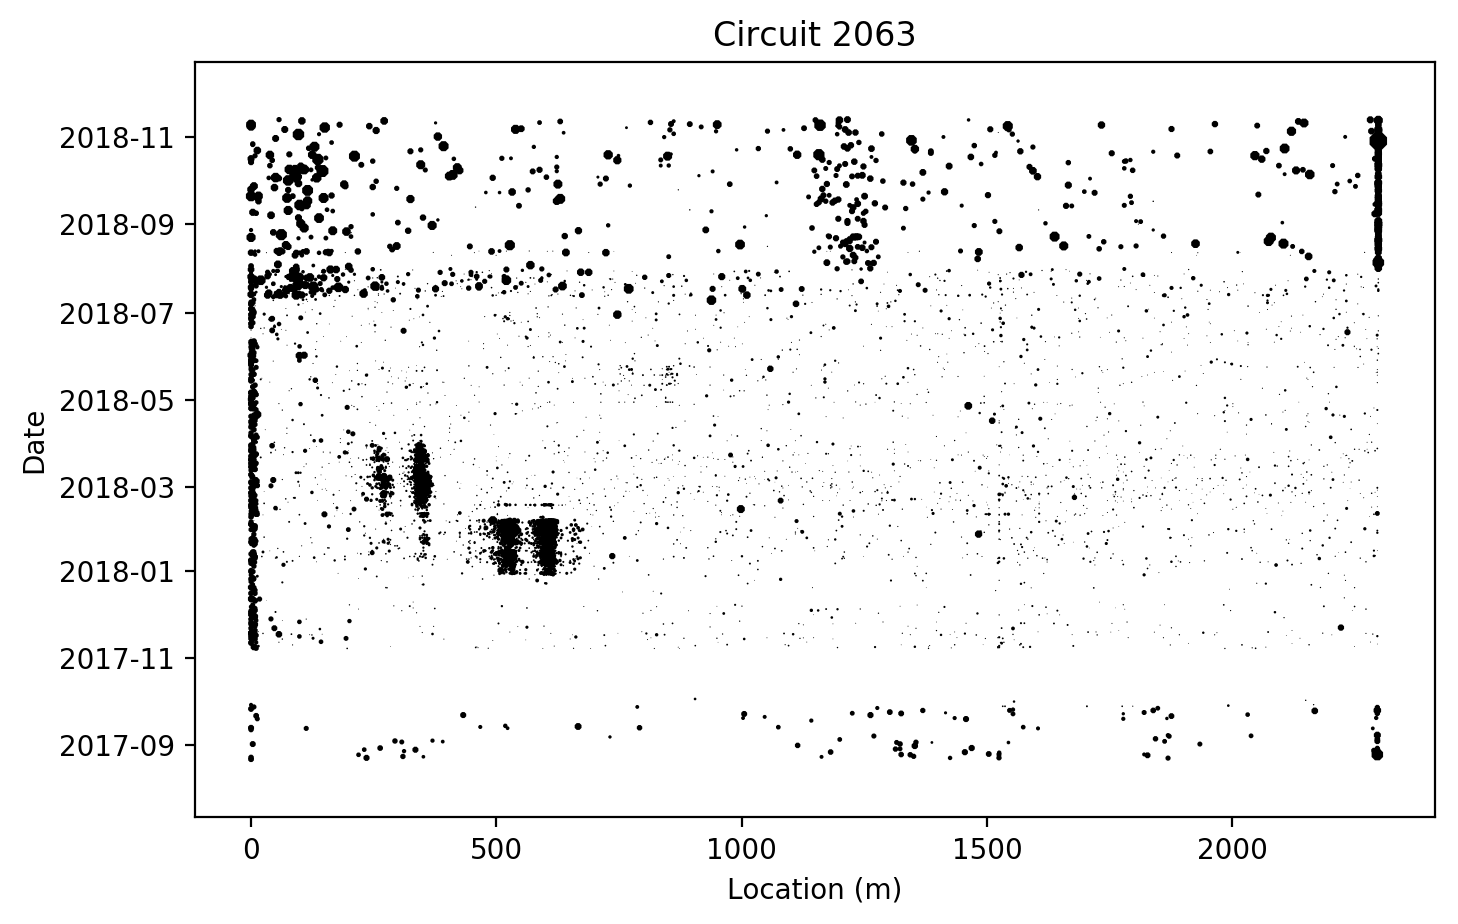

In [214]:
%matplotlib inline

fig, ax = plt.subplots(**plotargs)

clusterizer.plot.draw_location_time_scatter(circuit, ax=ax)

clusterizer.plot.save_figure_for_google_slides(pr+"A", reset_size=False)
clusterizer.plot.save_figure_for_latex(pr+"A", reset_size=False)

# Afstand discretiseren

In de data is afstand continu, dwz dat er (waarschijnlijk)\* geen twee PDs op precies dezelfde locatie plaatsvinden. Je kan dus nog niet praten over het 'aantal PDs op x meter'. Het lijkt dus nuttig om de afstand te discretiseren: opsplitsen in een eindig aantal 'bins', waarin elke PD-locatie valt.

\* Dit is niet helemaal waar, het aantal unieke locaties is ongeveer een tiende van het aantal PDs. Er is dus waarschijnlijk al gediscretiseerd, het lijkt elke 25cm te zijn.

In [215]:
rectangles, bins, bin_contents, nominal_pd_quantile_level, rate, fault_pd_level = clusterizer.algorithms.clusterize_poisson_1d(circuit, return_intermediate_values=True)

Saved to /notebooks/poisson_plots_1d_circuit_2063_B.png
Saved to /notebooks/poisson_plots_1d_circuit_2063_B.pdf


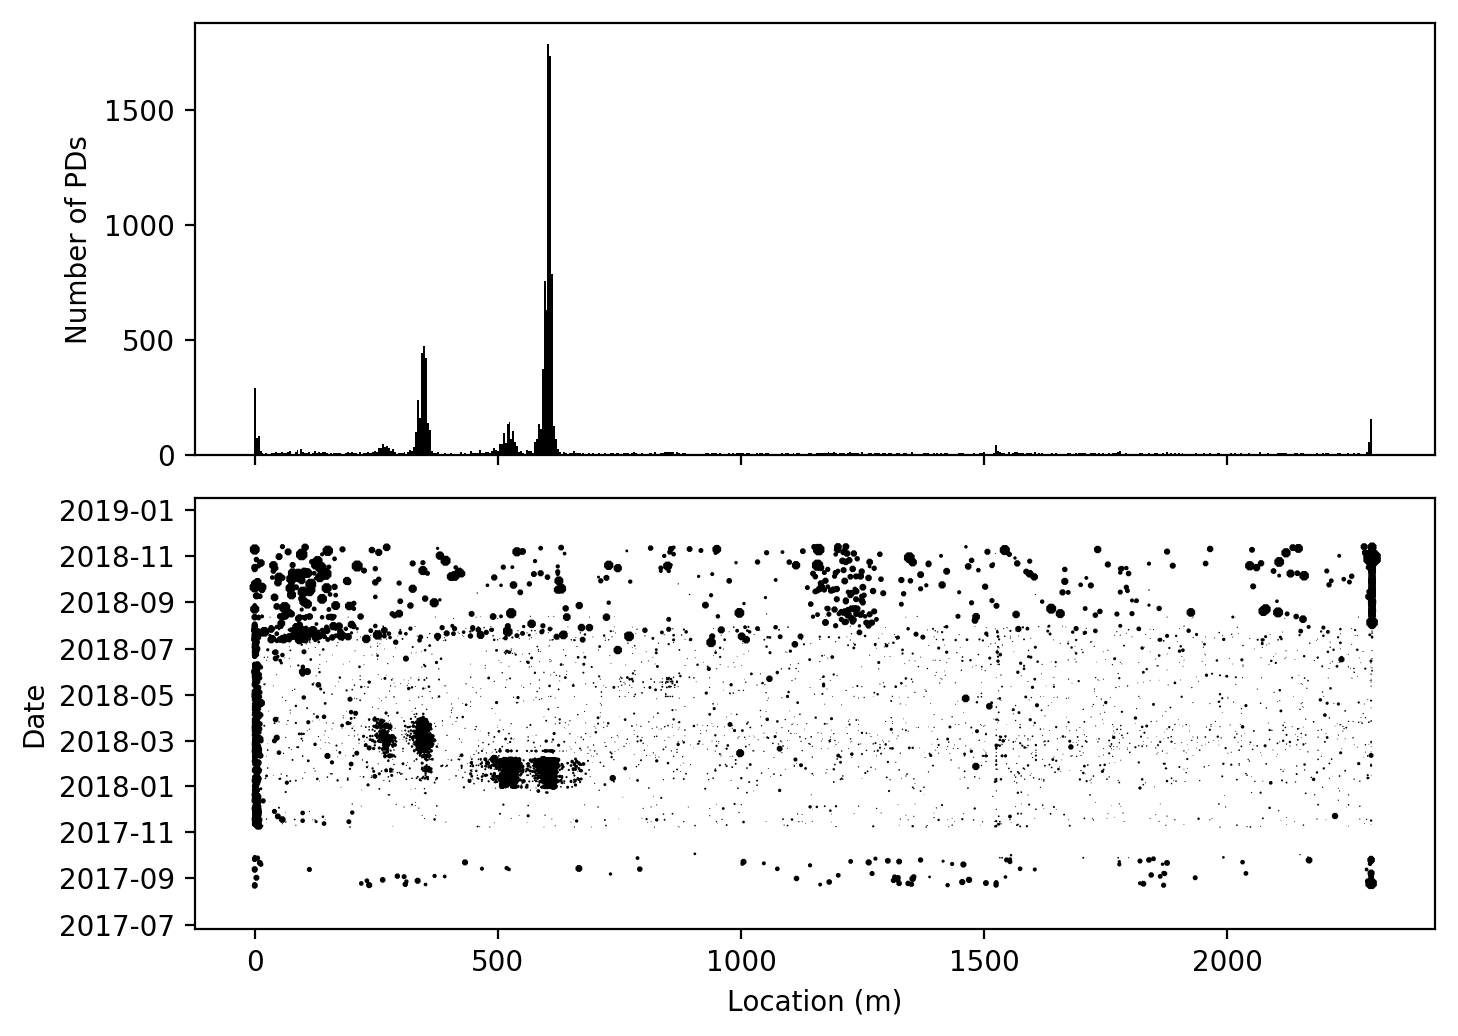

In [216]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,6), dpi=100)

plt.subplots_adjust(hspace=.1)

ax[0].bar(bins[:-1], bin_contents, width=(bins[1]-bins[0]), color="black")
clusterizer.plot.draw_location_time_scatter(circuit, ax[1])
ax[1].set_title(None)
ax[0].set_ylabel("Number of PDs")

clusterizer.plot.save_figure_for_google_slides(pr+"B", reset_size=False)
clusterizer.plot.save_figure_for_latex(pr+"B", reset_size=False)

## Aanname 1:
> Met het grootste gedeelte van de lijn is niks aan de hand.

We kiezen een **ondergrens voor het percentage locaties waarop niks aan de hand is**.

In [217]:
############ PARAMETER ############

lower_limit_nominal = 80.0/100.0

###################################

Saved to /notebooks/poisson_plots_1d_circuit_2063_C.png
Saved to /notebooks/poisson_plots_1d_circuit_2063_C.pdf


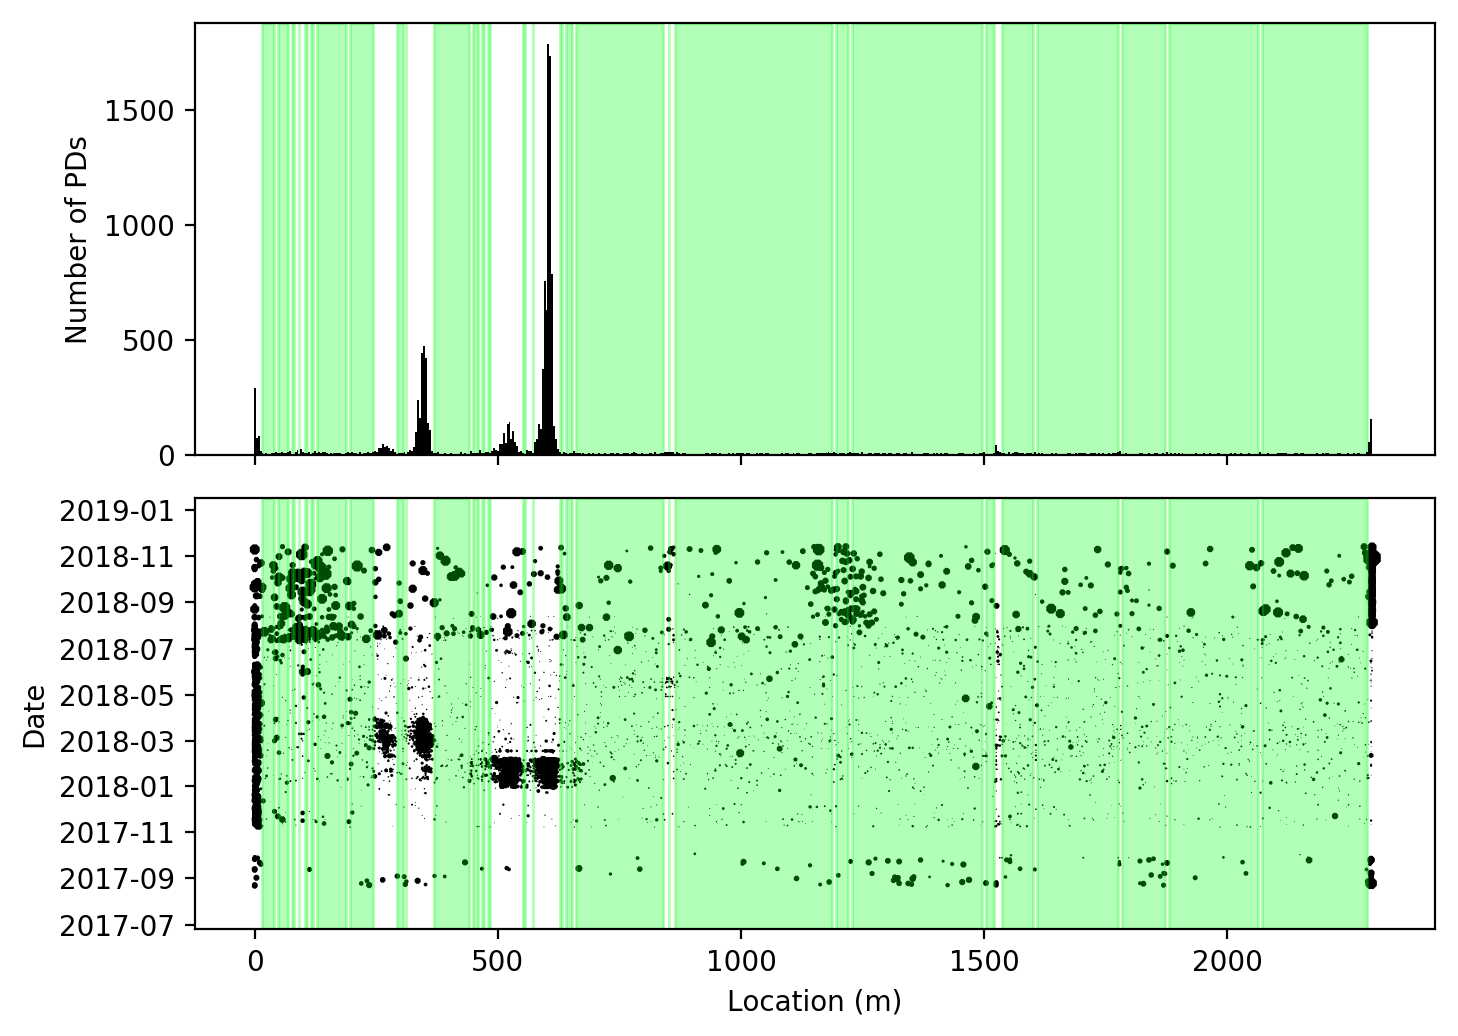

In [218]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,6), dpi=100)

plt.subplots_adjust(hspace=.1)

ax[0].bar(bins[:-1], bin_contents, width=(bins[1]-bins[0]), color="black")
clusterizer.plot.draw_location_time_scatter(circuit, ax[1])
ax[1].set_title(None)
ax[0].set_ylabel("Number of PDs")

clusterizer.plot.overlay_boolean_series(bin_contents <= nominal_pd_quantile_level, bins[:-1], ax=ax[0], color="#00ff11")
clusterizer.plot.overlay_boolean_series(bin_contents <= nominal_pd_quantile_level, bins[:-1], ax=ax[1], color="#00ff11")

clusterizer.plot.save_figure_for_google_slides(pr+"C", reset_size=False)
clusterizer.plot.save_figure_for_latex(pr+"C", reset_size=False)

Saved to /notebooks/poisson_plots_1d_circuit_2063_D.png
Saved to /notebooks/poisson_plots_1d_circuit_2063_D.pdf


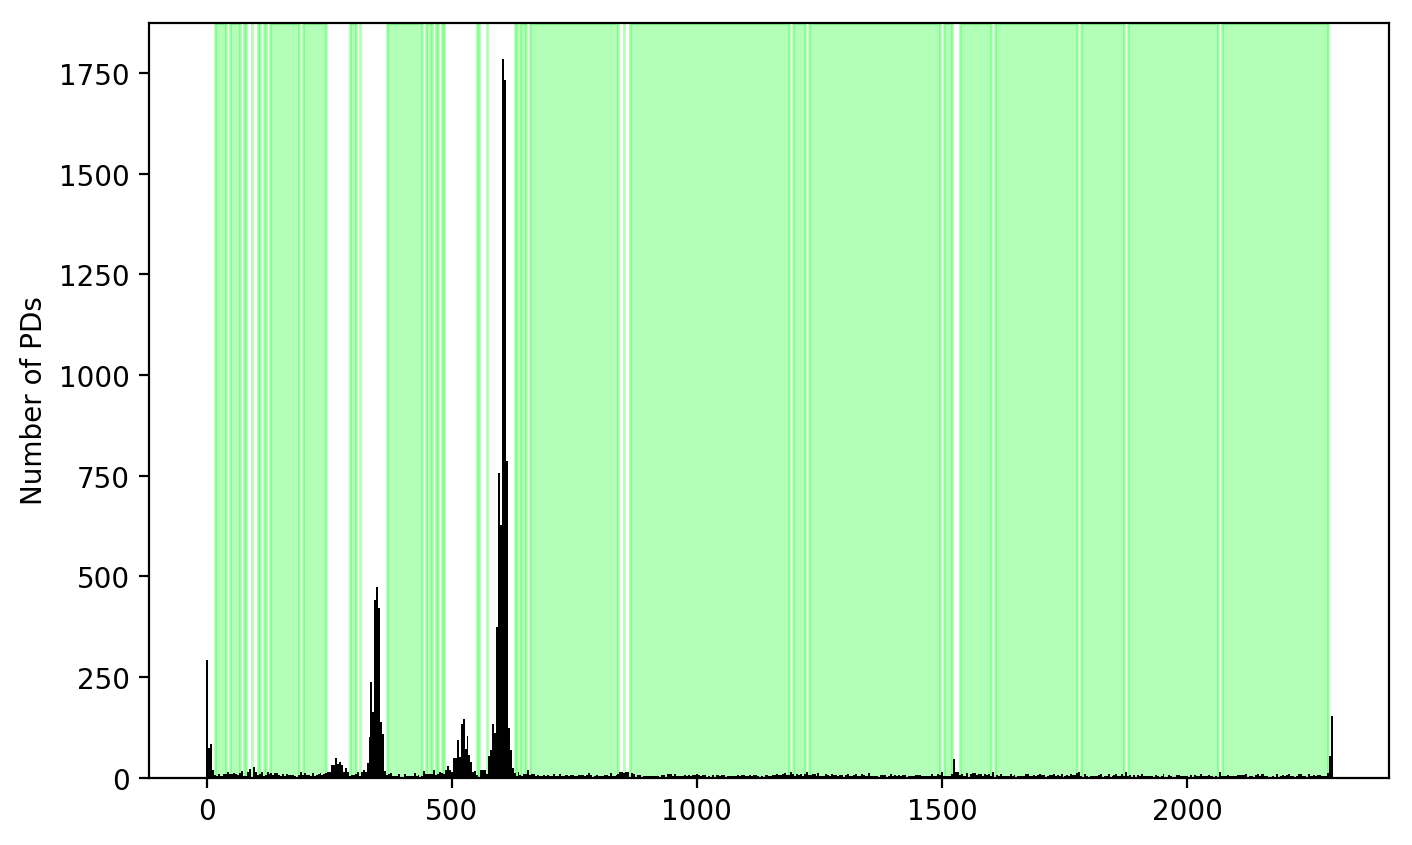

In [219]:
fig, ax = plt.subplots(**plotargs)

plt.subplots_adjust(hspace=.1)

ax.bar(bins[:-1], bin_contents, width=(bins[1]-bins[0]), color="black")
ax.set_ylabel("Number of PDs")

clusterizer.plot.overlay_boolean_series(bin_contents <= nominal_pd_quantile_level, bins[:-1], ax=ax, color="#00ff11")

clusterizer.plot.save_figure_for_google_slides(pr+"D", reset_size=False)
clusterizer.plot.save_figure_for_latex(pr+"D", reset_size=False)

Saved to /notebooks/poisson_plots_1d_circuit_2063_E.png
Saved to /notebooks/poisson_plots_1d_circuit_2063_E.pdf


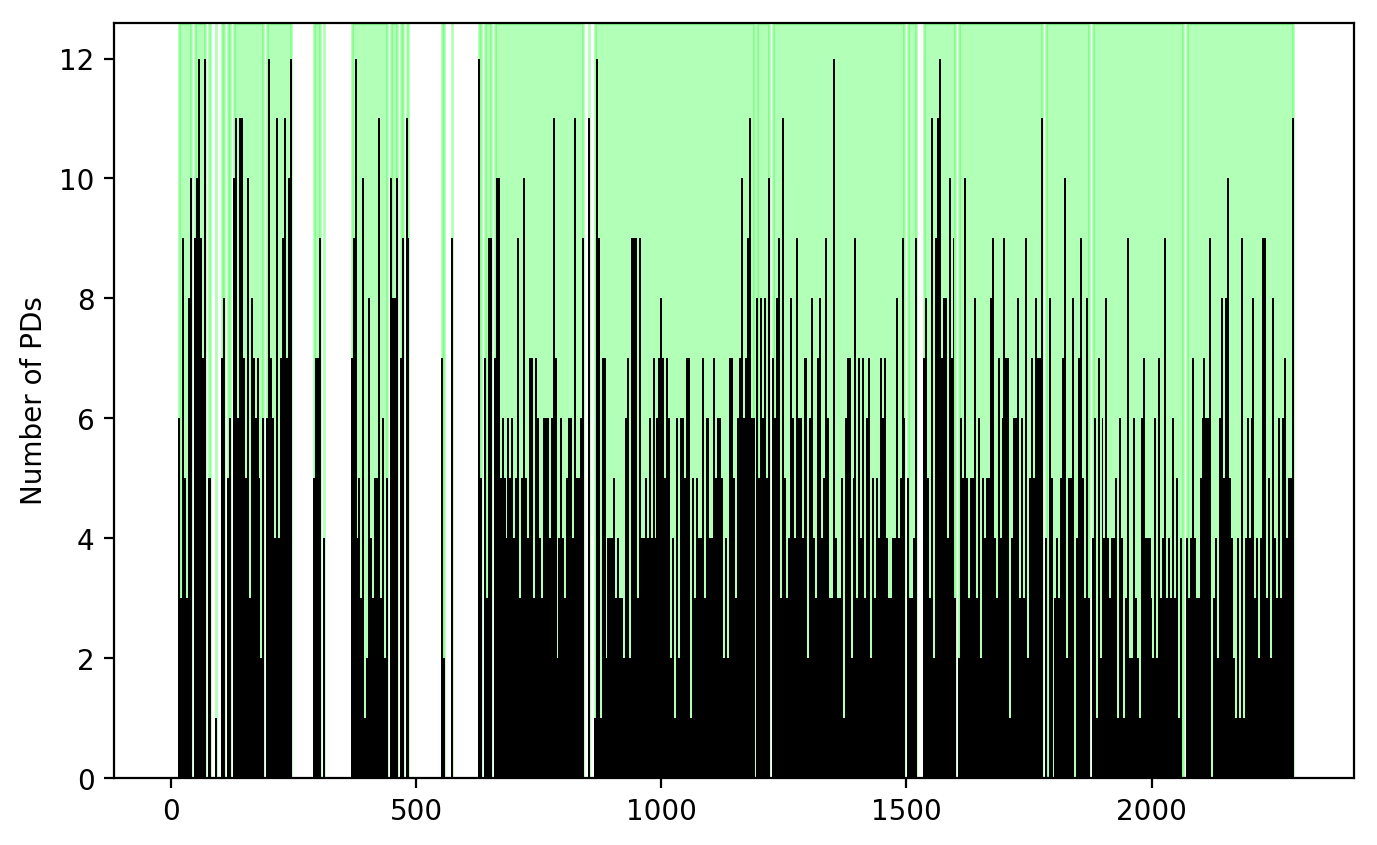

In [220]:
fig, ax = plt.subplots(**plotargs)

ax.bar(bins[:-1], bin_contents * (bin_contents <= nominal_pd_quantile_level), width=(bins[1]-bins[0]), color="black")
ax.set_ylabel("Number of PDs")

clusterizer.plot.overlay_boolean_series(bin_contents <= nominal_pd_quantile_level, bins[:-1], ax=ax, color="#00ff11")

clusterizer.plot.save_figure_for_google_slides(pr+"E", reset_size=False)
clusterizer.plot.save_figure_for_latex(pr+"E", reset_size=False)

Saved to /notebooks/poisson_plots_1d_circuit_2063_F.png
Saved to /notebooks/poisson_plots_1d_circuit_2063_F.pdf


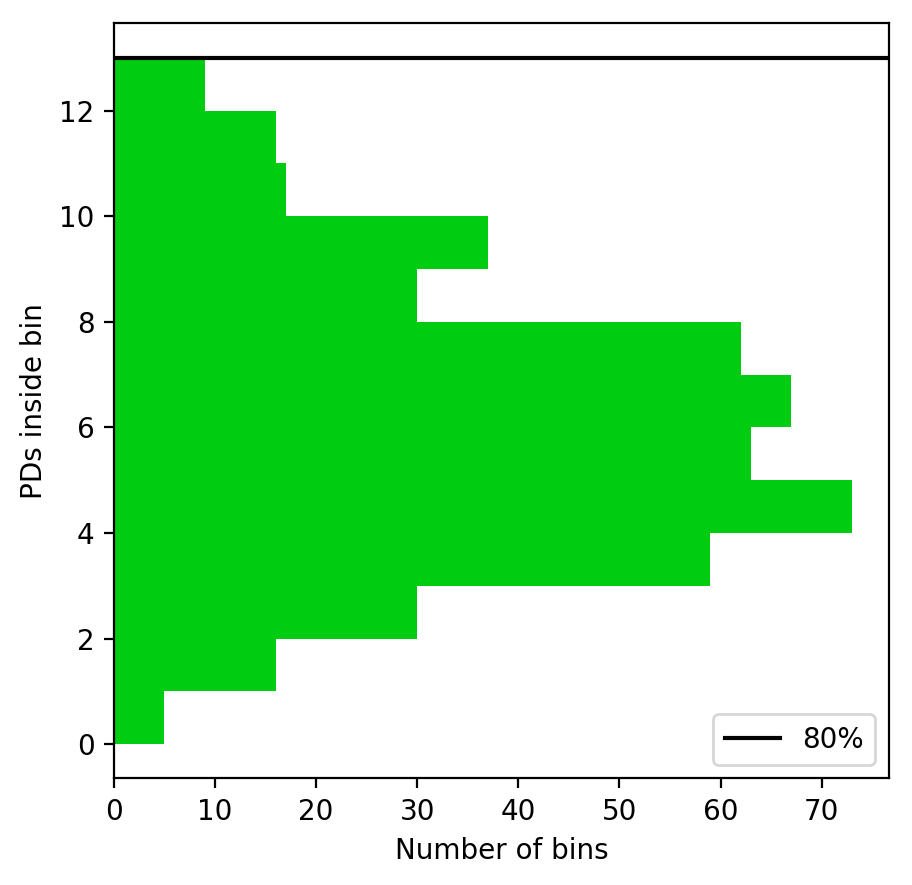

In [221]:
fig, ax = plt.subplots(figsize=(5,5), dpi=100)

#ax.bar(bins[:-1], bin_contents * (bin_contents <= nominal_pd_quantile_level), width=(bins[1]-bins[0]), color="black")
#ax.set_ylabel("Number of PDs")

lowpdcounts = bin_contents[bin_contents <= nominal_pd_quantile_level]

ax.hist(lowpdcounts, bins=range(max(lowpdcounts)+2), orientation="horizontal", color="#00cc11")
ax.axhline(nominal_pd_quantile_level+1, color="black", label="80%")
ax.set_xlabel("Number of bins")
ax.set_ylabel("PDs inside bin")
ax.legend()

#clusterizer.plot.overlay_boolean_series(bin_contents <= nominal_pd_quantile_level, bins[:-1], ax=ax, color="#00ff11")

clusterizer.plot.save_figure_for_google_slides(pr+"F", reset_size=False)
clusterizer.plot.save_figure_for_latex(pr+"F", reset_size=False)

Saved to /notebooks/poisson_plots_1d_circuit_2063_G.png
Saved to /notebooks/poisson_plots_1d_circuit_2063_G.pdf


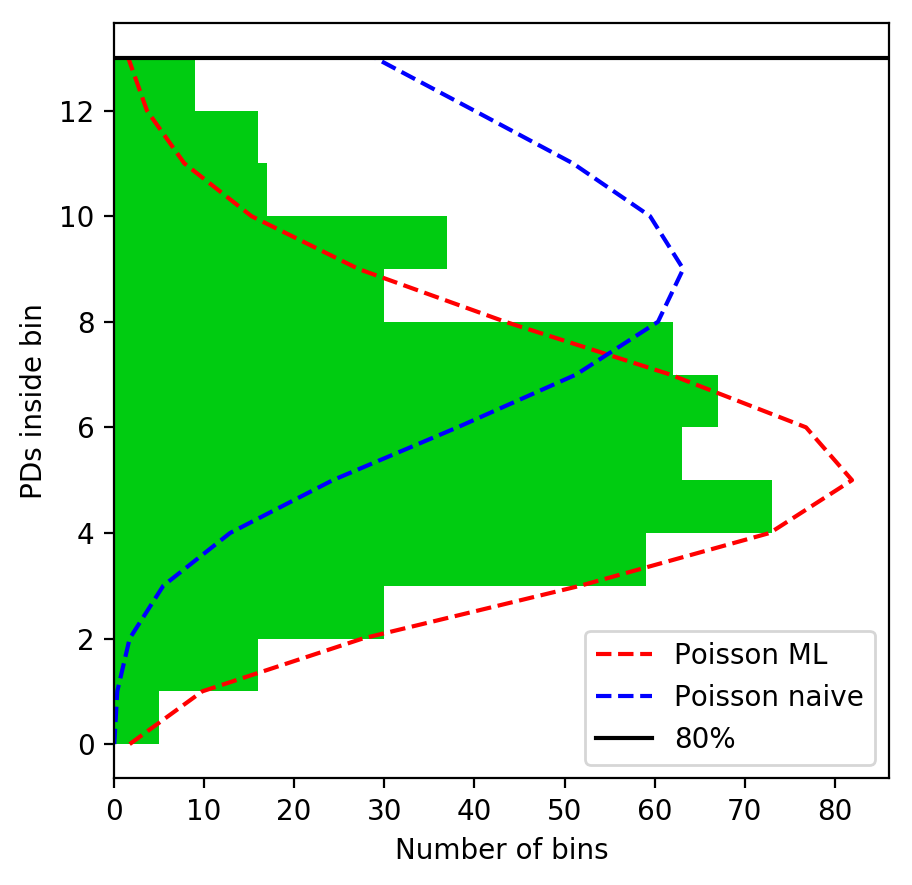

In [222]:
fig, ax = plt.subplots(figsize=(5,5), dpi=100)

#ax.bar(bins[:-1], bin_contents * (bin_contents <= nominal_pd_quantile_level), width=(bins[1]-bins[0]), color="black")
#ax.set_ylabel("Number of PDs")




lowpdcounts = bin_contents[bin_contents <= nominal_pd_quantile_level]
mean = np.mean(lowpdcounts)

y = np.arange(max(lowpdcounts)+2)

counts,_,_=ax.hist(lowpdcounts, bins=y, orientation="horizontal", color="#00cc11")
ax.plot(scipy.stats.poisson.pmf(y, mu=mean) * sum(counts), y, "--", color="red", label="Poisson ML")
ax.plot(scipy.stats.poisson.pmf(y, mu=rate) * sum(counts), y, "--", color="blue", label="Poisson naive")
ax.axhline(nominal_pd_quantile_level+1, color="black", label="80%")
ax.set_xlabel("Number of bins")
ax.set_ylabel("PDs inside bin")
ax.legend()

#clusterizer.plot.overlay_boolean_series(bin_contents <= nominal_pd_quantile_level, bins[:-1], ax=ax, color="#00ff11")

clusterizer.plot.save_figure_for_google_slides(pr+"G", reset_size=False)
clusterizer.plot.save_figure_for_latex(pr+"G", reset_size=False)

Sorteer de bakjes op inhoud, en beschouw de $\eta=0.8=$80% van de bakjes met de minste inhoud. De grens die we empirisch vinden noemen we $M_{\eta}$.

## Wilde aanname 2:
Het aantal PDs $X$ _op een nominaal stuk lijn_ is Poisson-verdeeld, $X \sim P(\lambda)$. Zó dat:

$$\mathbb{E}[X \leq M_{\eta}] = \eta.$$

(De kans dat X binnen de empirisch bepaalde 90% grens valt is exact 90%.)
Dit betekent dat als we veel samples uit deze Poisson-verdeling nemen, en we zoeken de grens van 90%, dan vinden we dezelfde $M_{\eta}$ en dan zouden we dezelfde $\lambda$ kiezen.

### Berekening $\lambda$

We kunnen de Poisson-verdling met parameter $\lambda$ schatten met een normaalverdeling $N(\mu = \lambda, \sigma^2 = \lambda)$. Stel $Y$ is zo verdeeld.

$$\mathbb{E}[Y \leq M_{\eta}] = \mathbb{E}[N(0,\lambda) \leq M_{\eta} - \lambda] = \mathbb{E}[N(0,1) \leq M_{\eta}/\sqrt{\lambda} - \sqrt{\lambda}] = \eta$$.

Dus $M_{\eta}/\sqrt{\lambda} - \sqrt{\lambda} = \Phi(\eta)$ en

$$\lambda = \frac{1}{4}\left(-\Phi(\eta) + \sqrt{\Phi(\eta)^2 + 4M_{\eta}}\right)^2.$$

($\Phi$ is de inverse van de verdelingsfunctie(?) (CDF) van de standaard normaalverdeling.)

## Wilde aanname 3:
Op plekken waar een fout zit is het aantal PDs _abnormaal hoog, volgens de gevonden Poisson-verdeling_. Abnormaal = 5 op 100?

In [223]:
############ PARAMETER ############

lower_limit_fault = 95.0 / 100.0

###################################

In [224]:
if rate == 0.0:
    # rate was zero: fault_pd_level should be zero, not nan
    fault_pd_level = 0.0
else:
    # Als ik de ppf van de scipy.stats.poisson gebruik krijg ik alleen maar resultaten heel dichtbij M_{\eta}
    # dat hoort niet (toch?)
    fault_pd_level = scipy.stats.norm.ppf(q=.95, loc=rate, scale=rate)

fault_pd_level

24.907298117432102

Saved to /notebooks/poisson_plots_1d_circuit_2063_H.png
Saved to /notebooks/poisson_plots_1d_circuit_2063_H.pdf


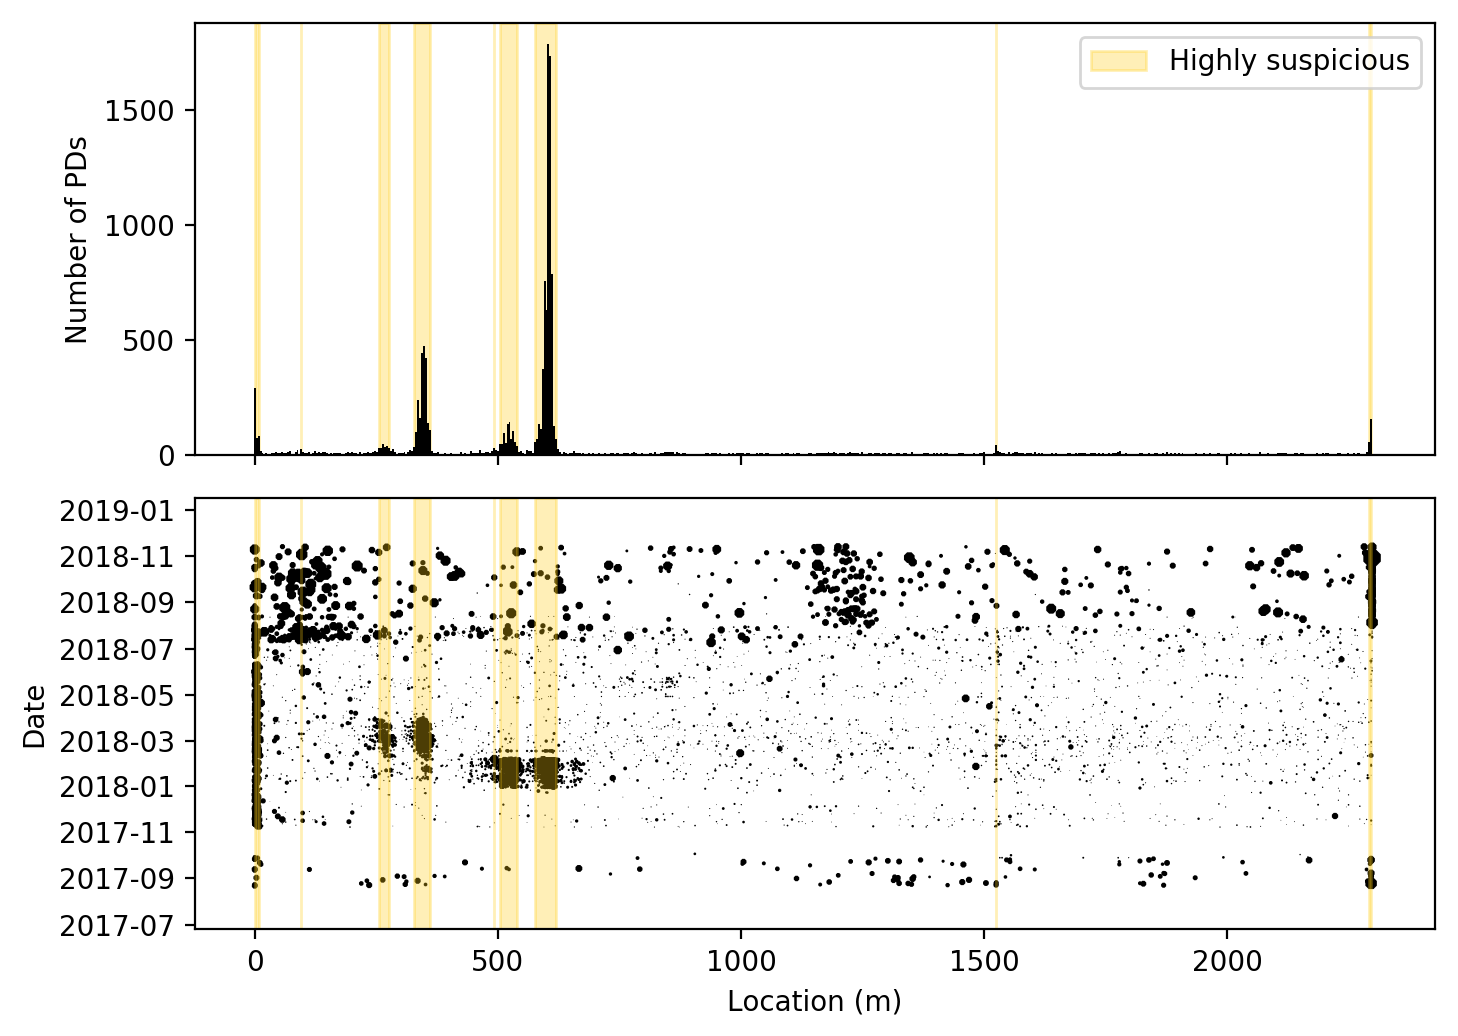

In [225]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,6), dpi=100)

plt.subplots_adjust(hspace=.1)

ax[0].bar(bins[:-1], bin_contents, width=(bins[1]-bins[0]), color="black")
clusterizer.plot.draw_location_time_scatter(circuit, ax[1])
ax[1].set_title(None)
ax[0].set_ylabel("Number of PDs")

clusterizer.plot.overlay_boolean_series(bin_contents > fault_pd_level, bins[:-1], ax=ax[0], color="#ffcc11", label="Highly suspicious")
clusterizer.plot.overlay_boolean_series(bin_contents > fault_pd_level, bins[:-1], ax=ax[1], color="#ffcc11", label="Highly suspicious")
ax[0].legend()

clusterizer.plot.save_figure_for_google_slides(pr+"H", reset_size=False)
clusterizer.plot.save_figure_for_latex(pr+"H", reset_size=False)

# Een simpel groupeeralgortime

We hebben nu een deelverzameling $W$ van de locaties van de bakjes, waarop het aantal PDs met zekerheid abnormaal hoog is. Het is te zien dat bij pieken hier een rij opeenvolgende getallen in staat, maar soms mist er eentje.

We definieren een cluster dmv twee parameters:
* Een 'gat' in het cluster is maximaal $n_{skip} \in \mathbb{N}$ groot.
* Het cluster heeft minimaal $m_{min} \in \mathbb{N}$ elementen.



In [226]:
# Found location clusters:
rectangles

{0m to 12m; Found by: Poisson 1D,
 256m to 280m; Found by: Poisson 1D,
 328m to 364m; Found by: Poisson 1D,
 492m to 544m; Found by: Poisson 1D,
 576m to 624m; Found by: Poisson 1D,
 2292m to 2300m; Found by: Poisson 1D}

Saved to /notebooks/poisson_plots_1d_circuit_2063_I.png
Saved to /notebooks/poisson_plots_1d_circuit_2063_I.pdf


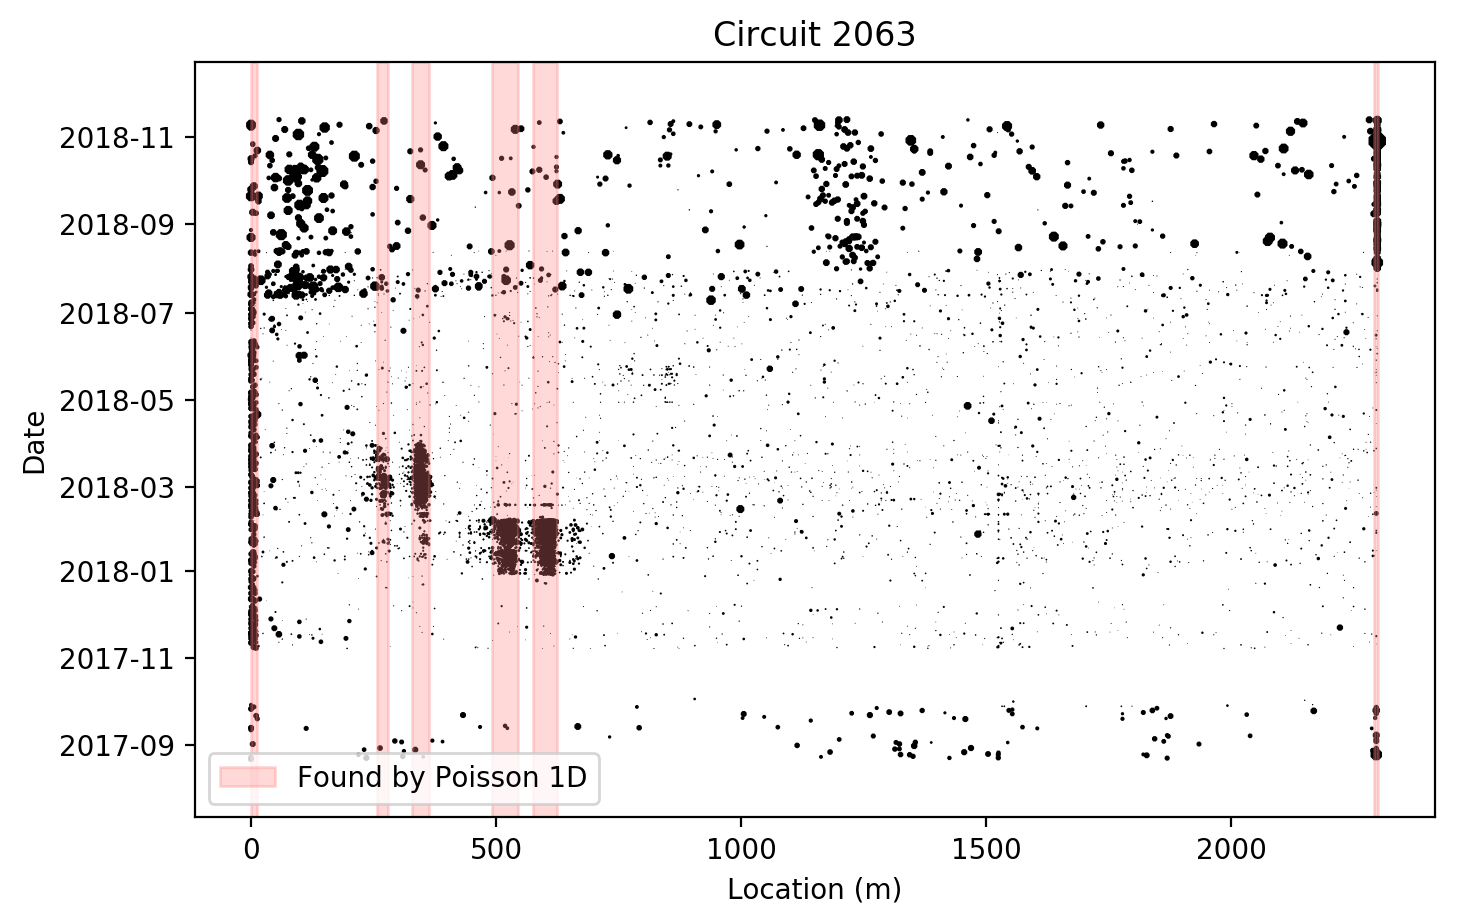

In [227]:
fig, ax = plt.subplots(**plotargs)

clusterizer.plot.draw_location_time_scatter(circuit, ax)
clusterizer.plot.overlay_cluster(rectangles, ax)
if rectangles:
    clusterizer.plot.legend_without_duplicate_labels(ax)



clusterizer.plot.save_figure_for_google_slides(pr+"I", reset_size=False)
clusterizer.plot.save_figure_for_latex(pr+"I", reset_size=False)

# Conclusie

Het werkt goed!
Door eerst de 80% marge te zoeken, en dan de onderste 80% te gebruiken om een verdeling te fitten, kan de ruis _gebruikt worden om te bepalen hoe bijzonder de uitschieters zijn_. Hierdoor vindt het bijvoorbeeld 0 clusters in de laatste sets (wat de bedoeling is).

In het tweede circuit wordt een cluster niet gevonden. Ik denk dat dit is omdat dat cluster maar korte duur had, en daarom in de lange dataset minder opvalt. (Er wordt namelijk gesommeerd over de volledige tijdreeks.) Dit kan overkomen worden door het algoritme los toe te passen op elke maand, bijvoorbeeld.